In [1]:
%load_ext autoreload

%autoreload 2

## Learning Improvement Heuristics for Solving the Travelling Salesman Problem (13)

Задача состояла в воспроизведении результатов статьи https://arxiv.org/pdf/1912.05784v1.pdf. Статья посвящена улучшению имеющихся решений проблемы коммивояжера с евклидовыми расстояниями между точками с использованием обучения с подкреплением. Были написаны среда и модель для проведения экспериментов. Был написан модуль обучения, но в проведенных экспериментах не получилось достичь точности рассматриваемых авторами solver'ов. Сравнение проивзодилось с API от компании Google OR-Tools.

### Постановка задачи
Опишем среду, действия и награды:
1. Множество состояний среды - множество всевозможных перестановок $n$ точек. 
2. Действия - обращения порядка следования точек в заданной перестановке между двумя выбранными точками.
3. Награда - в случае уменьшения суммарного расстояния между точками - разница между суммарным расстоянием до изменения и после, в случае увеличения/не изменения - ноль. 

В качестве алгоритма обучения использовался Actor-Critic с forward-view равным $k$. 

In [2]:
from src.architectures import Actor, Critic
from src.environment import TSPEnv
from src.train import train, train_one_batch
from src.heuristics import compute_distance, insert_heuristic, nearest_neighbour
from src.utils import sample_nodes
from src.presentation import test_metric_by_graph_size, compute_actor_distance

import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import timeit
import pickle
from tqdm import tqdm

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Использованные гиперпараметры

Размер графа - 20 точек. Для каждой эпохи генерируется 10240 графа (batch_size=256). Всего 200 эпох. Learning rate для оптимизатора Adam - $10^{-4}$. Дисконтирующий множетель наград - 0.99. Число шагов в farward-view - 4. Длительность улучшения решения - 200 шагов.

In [ ]:
batch_size = 256
TSP_size = 20

In [ ]:
actor = Actor().to(device)
critic = Critic(batch_size=batch_size, n=TSP_size).to(device)

In [ ]:
train_one_batch(actor, critic, device, batch_size=batch_size, epochs=1, TSP_size=TSP_size, batch_times=40)

In [ ]:
train(actor, critic, device, batch_size=batch_size, epochs=200, TSP_size=TSP_size, batch_times=40)

In [ ]:
torch.save(actor, './models/actor_20_new')

In [ ]:
torch.save(critic, './models/critic_20_new')

## Исследование различий в метриках

In [4]:
actor = torch.load('./models/actor_50_new')
actor.eval()

Actor(
  (linear_embedding): LinearEmbedding(
    (projection): Linear(in_features=2, out_features=128, bias=True)
  )
  (encoder): Encoder(
    (encoder_layers): ModuleList(
      (0): EncoderLayer(
        (s_att): AttentionLayer(
          (linear_v): Linear(in_features=128, out_features=128, bias=True)
          (linear_q): Linear(in_features=128, out_features=128, bias=True)
          (linear_k): Linear(in_features=128, out_features=128, bias=True)
        )
        (batch_norm_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (batch_norm_2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (ff): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
        )
      )
      (1): EncoderLayer(
        (s_att): AttentionLayer(
          (linear_v): Linear(in_features=128, out_features=128

In [5]:
f = open('distances.pkl', 'rb')

distances = pickle.load(f)
distances = np.array(distances)

f.close()

In [25]:
f = open('distances_new.pkl', 'rb')

distances_new = pickle.load(f)
distances_new = np.array(distances_new)

f.close()

In [6]:
f = open('dataset.pkl', 'rb')

dataset = pickle.load(f)

f.close()

In [7]:
batch_size = 200
TSP_size = 50
env = TSPEnv(n=TSP_size, batch_size=batch_size)

In [14]:
def compute_actor_distance(actor, window=1000, device='cpu', dots=None, distances=None):
    bsz, n, _ = dots.shape
    env = TSPEnv(n=n, batch_size=bsz)
    env.reset()
    env._dots = dots
    env._distances = distances
    observations = env.get_observations()
    dots = torch.Tensor(dots).to(device)
    permuted_dots = env.permute_dots(observations, dots)
    for t in np.arange(window):
        _, actions = sample_nodes(actor(permuted_dots))
        observations, _, _ = env.step(actions)
        permuted_dots = env.permute_dots(observations, dots)
    return env.get_best_length()

In [9]:
p_list = [1, 1.1, 1.25, 1.4, 1.5, 1.6, 1.75, 1.9, 2]

In [17]:
model_results = np.zeros((len(p_list), 2000//batch_size))
for p in tqdm(range(len(p_list))):
    for b in range(2000//batch_size):
        model_results[p, b] = compute_actor_distance(actor,\
                               window=1000,\
                               device=device,\
                               dots=dataset[b*batch_size:b*batch_size+batch_size],\
                               distances=distances[p, b*batch_size:b*batch_size+batch_size]).mean()



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

 11%|█████████▏                                                                         | 1/9 [04:32<36:17, 272.18s/it]

 22%|██████████████████▍                                                                | 2/9 [09:02<31:40, 271.48s/it]

 33%|███████████████████████████▋                                                       | 3/9 [13:25<26:53, 268.93s/it]

 44%|████████████████████████████████████▉                                              | 4/9 [17:43<22:09, 265.83s/it]

 56%|██████████████████████████████████████████████                                     | 5/9 [22:03<17:36, 264.17s/it]

 67%|███████████████████████████████████████████████████████▎                           | 6/9 [26:24<13:09, 263.22s/it]

 78%|████████████████████████████████████████████████████████████████▌                  | 7/9 [30:53<08:49, 264.78s/it]

 89%|█████████████████████████

In [26]:
model_results_new = np.zeros((len(p_list), 2000//batch_size))
for p in tqdm(range(len(p_list))):
    for b in range(2000//batch_size):
        model_results_new[p, b] = compute_actor_distance(actor,\
                               window=1000,\
                               device=device,\
                               dots=dataset[b*batch_size:b*batch_size+batch_size],\
                               distances=distances_new[p, b*batch_size:b*batch_size+batch_size]).mean()



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

 11%|█████████▏                                                                         | 1/9 [04:06<32:50, 246.30s/it]

 22%|██████████████████▍                                                                | 2/9 [08:21<29:02, 248.91s/it]

 33%|███████████████████████████▋                                                       | 3/9 [12:38<25:08, 251.46s/it]

 44%|████████████████████████████████████▉                                              | 4/9 [17:03<21:16, 255.38s/it]

 56%|██████████████████████████████████████████████                                     | 5/9 [21:16<16:59, 254.89s/it]

 67%|███████████████████████████████████████████████████████▎                           | 6/9 [25:28<12:42, 254.02s/it]

IndexError: index 6 is out of bounds for axis 0 with size 6

In [27]:
model_results_2 = np.array([model_results.mean(axis=1)[0],
                            model_results_new.mean(axis=1)[0],
                            model_results_new.mean(axis=1)[1],
                            model_results_new.mean(axis=1)[2],
                            model_results.mean(axis=1)[1],
                            model_results_new.mean(axis=1)[3],
                            model_results_new.mean(axis=1)[4],
                            model_results_new.mean(axis=1)[5],
                            model_results.mean(axis=1)[2]])

In [33]:
ortools_results = pd.read_csv('TOURS_RES+ORTOOLS.CSV', sep=';').to_numpy()[:,1:]

In [34]:
ortools_results_new = pd.read_csv('TOURS_RES+ORTOOLS_new.CSV', sep=';').to_numpy()[:,1:]

In [35]:
ortools_results_2 = np.array([ortools_results.mean(axis=1)[0],
                            ortools_results_new.mean(axis=1)[0],
                            ortools_results_new.mean(axis=1)[1],
                            ortools_results_new.mean(axis=1)[2],
                            ortools_results.mean(axis=1)[1],
                            ortools_results_new.mean(axis=1)[3],
                            ortools_results_new.mean(axis=1)[4],
                            ortools_results_new.mean(axis=1)[5],
                            ortools_results.mean(axis=1)[2]])

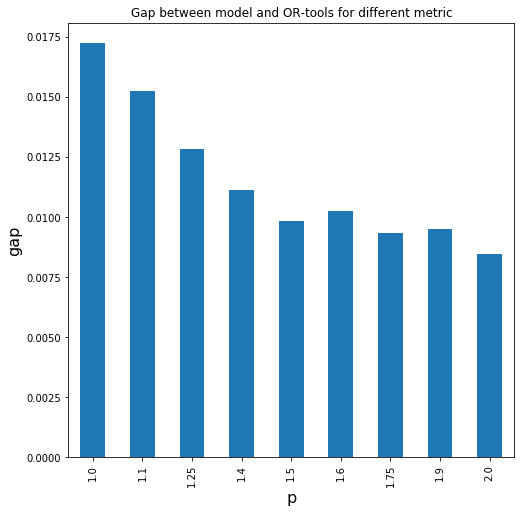

In [36]:
fig = plt.figure(figsize=(8,8))
pd.Series(1 - ortools_results_2/model_results_2, index=p_list).plot.bar()
plt.xlabel('p', fontsize=16)
plt.ylabel('gap', fontsize=16)
plt.title('Gap between model and OR-tools for different metric')
plt.savefig('L2I_gap.jpg')

### Замеры времени (20)

In [ ]:
actor = torch.load('./models/actor_20_new')
actor.eval()

In [ ]:
n = 20
batch_size = 256
env = TSPEnv(n=n, batch_size=batch_size)

#### 1000 шагов улучшения:

In [ ]:
%%time
env.reset(ret=False)
actor_distance_1000 = compute_actor_distance(actor, env, 1000, 'cuda')

In [ ]:
timeit.timeit(lambda: compute_actor_distance(actor, env, 1000, 'cuda'), number=20)

In [ ]:
356.41708169999765/20

#### 3000 шагов улучшения:

In [ ]:
%%time
env.reset(ret=False)
actor_distance_3000 = compute_actor_distance(actor, env, 3000, 'cuda')

In [ ]:
timeit.timeit(lambda: compute_actor_distance(actor, env, 3000, 'cuda'), number=20)

In [ ]:
1077.4684396000084/20

#### 5000 шагов улучшения:

In [ ]:
%%time
env.reset(ret=False)
actor_distance_5000 = compute_actor_distance(actor, env, 5000, 'cuda')

In [ ]:
timeit.timeit(lambda: compute_actor_distance(actor, env, 5000, 'cuda'), number=20)

In [ ]:
1763/20

Результаты:

In [ ]:
print('1000 steps:', actor_distance_1000.mean())
print('3000 steps:', actor_distance_3000.mean())
print('5000 steps:', actor_distance_5000.mean())

#### OR-tools

In [ ]:
dots = env.get_dots()
distances = env.get_distances()

In [ ]:
%%time
time_limit = 17.8/batch_size
or_1000_distances = []
for i in range(batch_size):
    or_1000_distances.append(compute_distance(distances[i], time_limit=time_limit))

In [ ]:
%%time
time_limit = 53.8/batch_size
or_3000_distances = []
for i in range(batch_size):
    or_3000_distances.append(compute_distance(distances[i], time_limit=time_limit))

In [ ]:
%%time
time_limit = 88.15/batch_size
or_3000_distances = []
for i in range(batch_size):
    or_3000_distances.append(compute_distance(distances[i], time_limit=time_limit))

In [ ]:
print(np.mean(or_1000_distances))
print(np.mean(or_3000_distances))
print(np.mean(or_5000_distances))

### Замеры времени (50)

In [ ]:
actor = torch.load('./models/actor_50_new')
actor.eval()

In [ ]:
n = 50
batch_size = 256
env = TSPEnv(n=n, batch_size=batch_size)

#### 1000 шагов улучшения:

In [ ]:
%%time
env.reset(ret=False)
actor_distance_1000 = compute_actor_distance(actor, env, 1000, 'cuda')

In [ ]:
timeit.timeit(lambda: compute_actor_distance(actor, env, 1000, 'cuda'), number=20)

In [ ]:
707.4920411/20

#### 3000 шагов улучшения:

In [ ]:
%%time
env.reset(ret=False)
actor_distance_3000 = compute_actor_distance(actor, env, 3000, 'cuda')

In [ ]:
timeit.timeit(lambda: compute_actor_distance(actor, env, 3000, 'cuda'), number=20)

In [ ]:
2151.0882115/20

#### 5000 шагов улучшения:

In [ ]:
%%time
env.reset(ret=False)
actor_distance_5000 = compute_actor_distance(actor, env, 5000, 'cuda')

In [ ]:
timeit.timeit(lambda: compute_actor_distance(actor, env, 5000, 'cuda'), number=20)

In [ ]:
3547.4055358000005/20

Средний результат:

In [ ]:
print('1000 steps:', actor_distance_1000.mean())
print('3000 steps:', actor_distance_3000.mean())
print('5000 steps:', actor_distance_5000.mean())

In [ ]:
dots = env.get_dots()
distances = env.get_distances()

#### OR-tools

In [ ]:
%%time
time_limit = 35.3/batch_size
or_1000_distances = []
for i in range(batch_size):
    or_1000_distances.append(compute_distance(distances[i], time_limit=time_limit))

In [ ]:
%%time
time_limit = 107/batch_size
or_3000_distances = []
for i in range(batch_size):
    or_3000_distances.append(compute_distance(distances[i], time_limit=time_limit))

In [ ]:
%%time
time_limit = 177/batch_size
or_5000_distances = []
for i in range(batch_size):
    or_5000_distances.append(compute_distance(distances[i], time_limit=time_limit))

Результаты:

In [ ]:
print(np.mean(or_1000_distances))
print(np.mean(or_3000_distances))
print(np.mean(or_5000_distances))

In [ ]:
n = 20
batch_size = 1
env = TSPEnv(n=n, batch_size=batch_size)

In [ ]:
actor = torch.load('./models/actor_20_new')
actor.eval()

In [ ]:
timeit.timeit(lambda: compute_actor_distance(actor, env, 1000, 'cuda'), number=20)

In [ ]:
timeit.timeit(lambda: compute_actor_distance(actor, env, 3000, 'cuda'), number=20)

In [ ]:
timeit.timeit(lambda: compute_actor_distance(actor, env, 5000, 'cuda'), number=20)

In [ ]:
n = 50
batch_size = 1
env = TSPEnv(n=n, batch_size=batch_size)

In [ ]:
actor = torch.load('./models/actor_50_new')
actor.eval()

In [ ]:
timeit.timeit(lambda: compute_actor_distance(actor, env, 1000, 'cuda'), number=20)

In [ ]:
timeit.timeit(lambda: compute_actor_distance(actor, env, 3000, 'cuda'), number=20)

In [ ]:
timeit.timeit(lambda: compute_actor_distance(actor, env, 5000, 'cuda'), number=20)

### Сравнение на новом графе (50)

Случайно инициализированный граф, на котором в течение 5000 шагов производится улучшение случайного начального.

In [ ]:
actor = torch.load('./models/actor_50_new')
actor.eval()

In [ ]:
n_space = np.arange(41, 60)

In [ ]:
results_41_59 = test_metric_by_graph_size(actor, n_space, number_of_graphs=256, window=5000, device='cuda')

In [ ]:
pd.DataFrame(results_41_59).to_csv('results_41_59.csv')

### Сравнение на новом графе (20)

In [ ]:
actor = torch.load('./models/actor_20_new')
actor.eval()

In [ ]:
n_space = np.arange(11, 30)

In [ ]:
results_11_29 = test_metric_by_graph_size(actor, n_space, number_of_graphs=256, window=5000, device='cuda')

In [ ]:
pd.DataFrame(results_11_29).to_csv('results_11_29.csv')

### Генерация датасетов

In [ ]:
for n in np.arange(20, 90, 10):
    env = TSPEnv(n=n, batch_size=256)
    env.save_graph("dataset_"+str(n)+".pkl")

### Графики обощения

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
df_50 = pd.read_csv('./results/results_50.csv', index_col=0)
df_20 = pd.read_csv('./results/results_20.csv', index_col=0)
df_10_30 = pd.read_csv('./results/results_11_29.csv', index_col=0)
df_40_60 = pd.read_csv('./results/results_41_59.csv', index_col=0)

In [ ]:
columns = ['nearest_neighbour', 'closest_heuristic', 'farthest_heuristic', 'or-tools', 'model']

In [ ]:
index_50 = np.arange(20, 90, 10)
index_10_30 = np.arange(11, 30)
index_40_60 = np.arange(41, 60)

In [ ]:
df_50.columns = columns
df_50.index = index_50
df_20.columns = columns
df_20.index = index_50
df_10_30.columns = columns
df_10_30.index = index_10_30
df_40_60.columns = columns
df_40_60.index = index_40_60

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.plot(df_10_30)
plt.title('TSP20 for 11-29')
plt.legend(columns)
plt.grid()
plt.xlabel('N - graph size', fontsize=20)
plt.ylabel('Average found distance', fontsize=20)
plt.savefig('./results/TSP20 for 11-29.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.plot(df_20)
plt.title('TSP20 for 20-80')
plt.legend(columns)
plt.grid()
plt.xlabel('N - graph size', fontsize=20)
plt.ylabel('Average found distance', fontsize=20)
plt.savefig('./results/TSP20 for 20-80.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.plot(df_50)
plt.title('TSP50 for 20-80')
plt.legend(columns)
plt.grid()
plt.xlabel('N - graph size', fontsize=20)
plt.ylabel('Average found distance', fontsize=20)
plt.savefig('./results/TSP50 for 20-80.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.plot(df_40_60)
plt.title('TSP50 for 41-59')
plt.legend(columns)
plt.grid()
plt.xlabel('N - graph size', fontsize=20)
plt.ylabel('Average found distance', fontsize=20)
plt.savefig('./results/TSP50 for 41-59.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.plot((df_10_30['model'] - df_10_30['or-tools'])/df_10_30['or-tools']*100)
plt.title('TSP20 GAP for 11-29')
plt.grid()
plt.xlabel('N - graph size', fontsize=20)
plt.ylabel('%', fontsize=20)
plt.legend(['gap between model and OR-tools'])
#plt.savefig('./results/TSP20 GAP for 11-29.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.plot((df_20['model'] - df_20['or-tools'])/df_20['or-tools']*100)
plt.title('TSP20 GAP for 20-80')
plt.grid()
plt.xlabel('N - graph size', fontsize=20)
plt.ylabel('%', fontsize=20)
plt.legend(['gap between model and OR-tools'])
plt.savefig('./results/TSP20 GAP for 20-80.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.plot((df_50['model'] - df_50['or-tools'])/df_50['or-tools']*100)
plt.title('TSP50 GAP for 20-80')
plt.grid()
plt.xlabel('N - graph size', fontsize=20)
plt.ylabel('%', fontsize=20)
plt.legend(['gap between model and OR-tools'])
plt.savefig('./results/TSP50 GAP for 20-80.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.plot((df_40_60['model'] - df_40_60['or-tools'])/df_40_60['or-tools']*100)
plt.title('TSP50 GAP for 41-59')
plt.grid()
plt.xlabel('N - graph size', fontsize=20)
plt.ylabel('%', fontsize=20)
plt.legend(['gap between model and OR-tools'])
plt.savefig('./results/TSP50 GAP for 41-59.png')

### Анимация простейших эвристик
Для графов размера 20

In [ ]:
from src.heuristics import insert_heuristic, nearest_neighbour
from src.presentation import get_gif_animation_heuristics

In [ ]:
n = 20
env = TSPEnv(n=n, batch_size=1)
dots = env.get_dots()
distances = env.get_distances()

#### Эвристики ближайшей и удаленнейшей вставки

In [ ]:
interval = 1400

Удаленнейшая вставка:

In [ ]:
_, _, seq, nodes = insert_heuristic(distances)
dots_seq = [dots[:, seq[i],:].squeeze() for i in range(len(seq))]
one_dot_seq = [dots[:, nodes[i], :].squeeze() for i in range(len(dots_seq[0])-1, len(nodes))]

In [ ]:
get_gif_animation_heuristics('./results/remote_gif_20.gif', dots_seq, one_dot_seq, interval)

Ближайшая вставка:

In [ ]:
_, _, seq, nodes = insert_heuristic(distances, insert_type='close')
dots_seq = [dots[:, seq[i],:].squeeze() for i in range(len(seq))]
one_dot_seq = [dots[:, nodes[i], :].squeeze() for i in range(len(dots_seq[0])-1, len(nodes))]

In [ ]:
get_gif_animation_heuristics('./results/close_gif_20.gif', dots_seq, one_dot_seq, interval)

#### Эвристика ближайшего соседа

In [ ]:
_, _, seq, nodes = nearest_neighbour(distances)
dots_seq = [dots[:, seq[i],:].squeeze() for i in range(len(seq))]
one_dot_seq = [dots[:, nodes[i], :].squeeze() for i in range(len(dots_seq[0])-1, len(nodes))]

In [ ]:
get_gif_animation_heuristics('./results/nearest_neighbour_20.gif', dots_seq, one_dot_seq, interval)